In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm, norm

In [2]:
def soft_threshold(v, thr_lambda):
    return np.sign(v) * np.maximum(abs(v) - thr_lambda, np.zeros_like(v))

## Generative model

In [3]:
# y = X * beta + epsilon
M = 5 # dimensionality of observations
K = 10 # dimensionality of coefficients
X = np.random.normal(loc=0.0, scale=1.0, size=(M, K))
beta = np.random.normal(loc=0.0, scale=1.0, size=K) * np.random.binomial(n=1, p=0.5, size=K) # Bernoulli-Gaussian model
epsilon = np.random.normal(loc=0.0, scale=1.0, size=M)
y = np.matmul(X, beta) + epsilon
T = 1 # number of LISTA layers
L = 10 # Lapunov constant
thr_lambda = 0.1

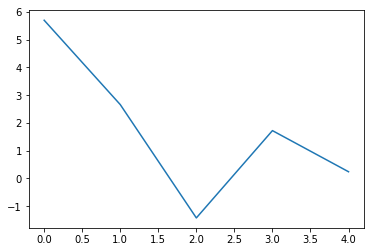

In [4]:
plt.plot(y)
plt.show()

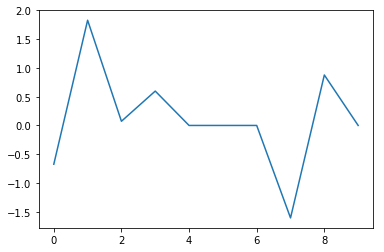

In [5]:
plt.plot(beta)
plt.show()

### Initialization

In [6]:
X_e = 1 / L * X.T
S = np.eye(K) - 1 / L * np.matmul(X.T, X)

### LISTA 0

In [7]:
B = np.matmul(X_e, y)
beta_cur = soft_threshold(B, thr_lambda)

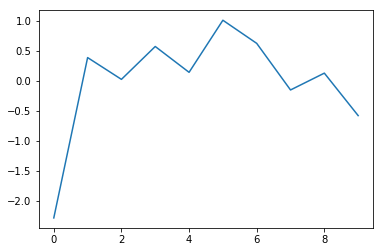

In [8]:
plt.plot(B)
plt.show()

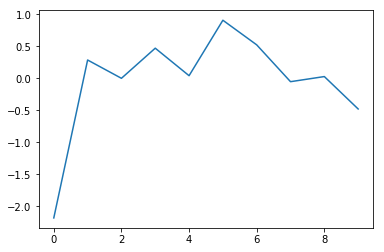

In [9]:
plt.plot(beta_cur)
plt.show()

In [10]:
test_s_thr = soft_threshold(np.linspace(-2, 2, 1000), 0.2)

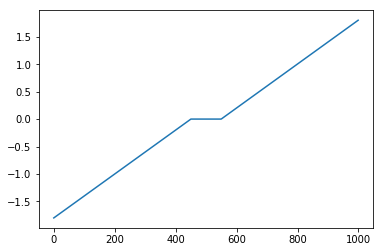

In [11]:
plt.plot(test_s_thr)
plt.show()

## LISTA T

In [12]:
for t in range(0, T):
    C = B + np.matmul(S, beta_cur)
    beta_cur = soft_threshold(C, thr_lambda)

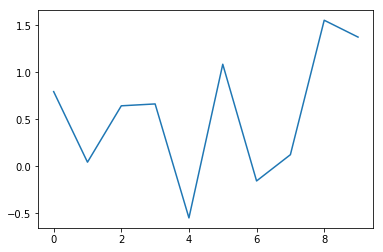

In [13]:
plt.plot(beta_cur)
plt.show()

# Propagate distributions

### Gaussian through soft-thresholding

In [14]:
sample_size = np.int(1e+6)

In [29]:
points = np.random.normal(loc=0.0, scale=1.0, size=sample_size)
points_propagated = soft_threshold(points, thr_lambda)

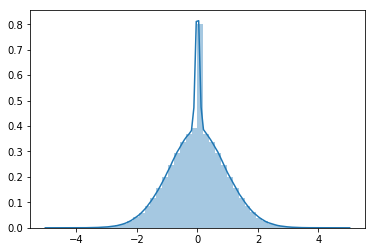

In [30]:
sns.distplot(points_propagated)
plt.show()

In [17]:
np.std(points_propagated[np.nonzero(points_propagated)])

0.87084229476493835

In [18]:
# compute the mean and variance of truncated distributions that will be approximated with slab

my_mean = 0.
my_std = 1.
infty = 1e+12

mean_right, var_right, skew, kurt = truncnorm.stats(
    a= (thr_lambda-my_mean) / my_std, 
    b= infty, 
    moments='mvsk')
mean_left, var_left, skew, kurt = truncnorm.stats(
    a= -infty, 
    b= (-thr_lambda-my_mean) / my_std, 
    moments='mvsk')

# slab
mean_approx = mean_left + mean_right
var_approx = var_left + var_right

# spike
omega = norm.cdf((thr_lambda - my_mean) / my_std) - norm.cdf((-thr_lambda - my_mean) / my_std)

# sample from resulting spike_and_slab
s_approx = np.random.normal(loc=mean_approx, scale=np.sqrt(var_approx), size=sample_size) * np.random.binomial(n=1, p=1-omega, size=sample_size)

In [19]:
np.sqrt(var_approx)

0.82722771346548585

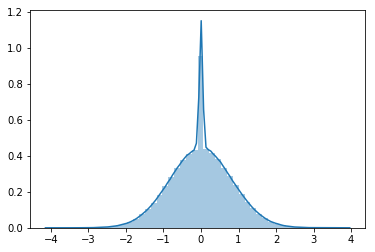

In [20]:
sns.distplot(s_approx)
plt.show()

In [37]:
def compute_slab_moments_for_thresholded_gaussian(mu, sigma2, thr_lambda):
    sigma = np.sqrt(sigma2)
    right_mean = sigma/np.sqrt(2*np.pi) * np.exp(-(thr_lambda-mu)**2/(2*sigma2)) + mu*(1-norm.cdf((thr_lambda-mu)/sigma))
    left_mean = -sigma/np.sqrt(2*np.pi) * np.exp(-(thr_lambda+mu)**2/(2*sigma2)) + mu*norm.cdf((-thr_lambda-mu)/sigma)
    right_2nd = sigma * (thr_lambda + mu)/np.sqrt(2*np.pi) * np.exp(-(thr_lambda-mu)**2/(2*sigma2)) + \
        (sigma2 + mu**2)*(1-norm.cdf((thr_lambda-mu)/sigma))
    left_2nd = sigma * (thr_lambda - mu)/np.sqrt(2*np.pi) * np.exp(-(thr_lambda+mu)**2/(2*sigma2)) + \
        (sigma2 + mu**2)*norm.cdf(-(thr_lambda+mu)/sigma)
    mean = right_mean + left_mean
    moment2 = right_2nd + left_2nd
    var = moment2 - mean ** 2
    return mean, var

In [38]:
mean_approx2, var_approx2 = compute_slab_moments_for_thresholded_gaussian(mu=0., sigma2=1., thr_lambda=thr_lambda)

In [39]:
s_approx2 = np.random.normal(loc=mean_approx2, scale=np.sqrt(var_approx2), size=sample_size) * \
np.random.binomial(n=1, p=1-omega, size=sample_size)

In [40]:
np.sqrt(var_approx2)

0.99986740868044321

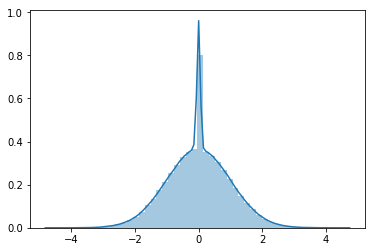

In [41]:
sns.distplot(s_approx2)
plt.show()